# Problem description

To a large degree, financial data has traditionally been numeric in format.

But in recent years, non-numeric formats like image, text and audio have been introduced.  

Private companies have satellites orbiting the Earth taking photos and offering them to customers.  A financial analyst might be able to extract information from these photos that could aid in the prediction of the future price of a stock

- Approximate number of customers visiting each store: count number of cars in parking lot
- Approximate activity in a factory by counting number of supplier trucks arriving and number of delivery trucks leaving
- Approximate demand for a commodity at each location: count cargo ships traveling between ports

In this assignment, we will attempt to recognize ships in satellite photos.
This would be a first step toward
counting.

As in any other domain: specific knowledge of the problem area will make you a better analyst.
For this assignment, we will ignore domain-specific information and just try to use a labeled training set (photo plus a binary indicator for whether a ship is present/absent in the photo), assuming that the labels are perfect.

n.b., it appears that a photo is labeled as having a ship present only if the ship is in the center of the photo.  Perhaps this prevents us from double-counting.


## Goal: 
There are two notebook files in this assignment:
- **`Ships_in_satellite_images.ipynb`:** First and only notebook you need to work on. Train your models and save them
- **`Model_test.ipynb`:** Test your results. After you complete the `Ships_in_satellite_images.ipynb`, this notebook will be submitted

**Before you start working on this assignment, please check if your kernel is Python 3.7 (Right top of the page). If it is not Python 3.7, please go to `Kernel->Change kernel->Python 3.7` on the top**

In this notebook, you will need to create Sequential models in Keras to classify satellite photos.
- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

You will create several models, of increasing complexity
- A model that implements only a Classification Head (no transformations other than perhaps rearranging the image)
- A model that adds a Dense layer before the head
- (Later assignment) A model that adds Convolutional layers before the Head

## Learning objectives
- Learn how to construct Neural Networks using Keras Sequential model
- Appreciate how layer choices impact number of weights

# Imports modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


## Import tensorflow and check the version
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.0.0
Version 2, minor 0


# API for students

We have defined some utility routines in a file `nn_helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = nn_helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`

In [2]:
## Load the nn_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import nn_helper module
import nn_helper
%aimport nn_helper

helper = nn_helper.Helper()

# Create the dataset

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/ships_in_satellite_images/data"
       
json_file =  "shipsnet.json"

# Get the data
data, labels = helper.getData(DATA_DIR, json_file)
n_samples, width, height, channel = data.shape
print("Date shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))


Date shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


In [4]:
# Shuffle the data first
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

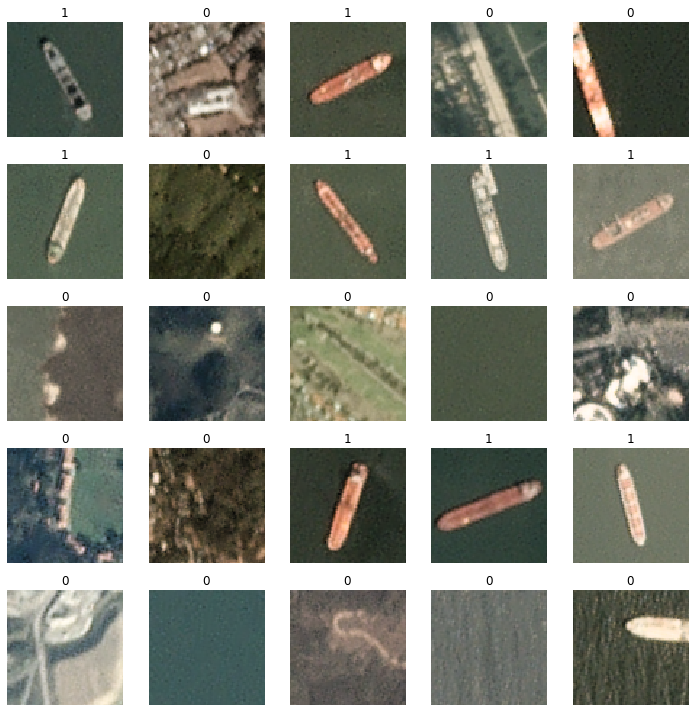

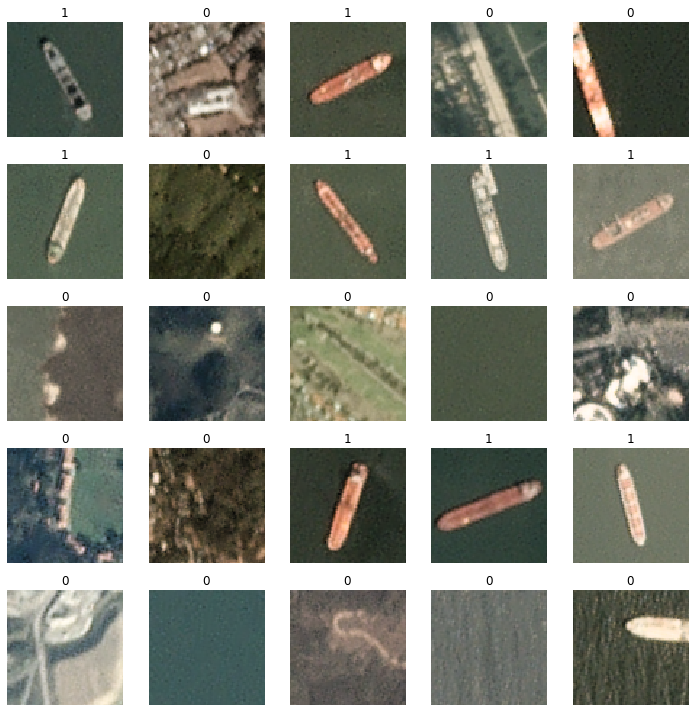

In [5]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])

## Examine the image/label pairs
We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


/home/kjp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


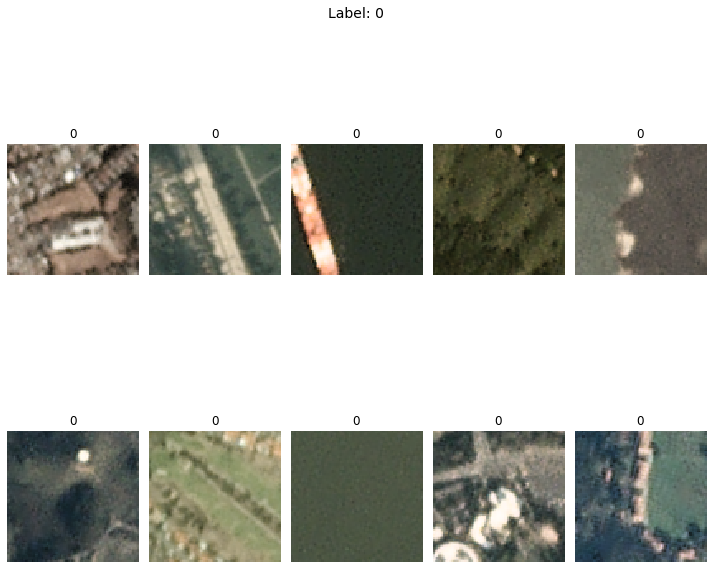

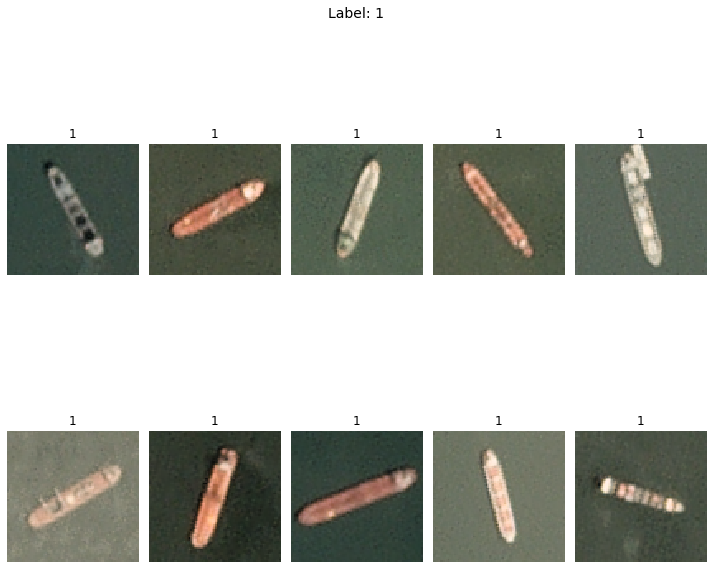

In [6]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ])
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    _ = fig.show()
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255. In addition, we usually use one-hot encoding to deal with our labels. 

**Hint** To encode your labels you may want to look up the method:
- `to_categorical()`, which is in `tensorflow.keras.utils` 

In [7]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

### BEGIN SOLUTION
X = data / 255.
y = to_categorical(labels, 2)
### END SOLUTION

In [8]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80, 3)
assert y.shape == (4000, 2)
assert (y[0][0] == 0.) and (y[0][1] == 1.)


Your expected output should be:  
`X shape: (4000, 80, 80, 3)`   
`y shape: (4000, 2)`  
`[0. 1.]`

# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell


In [9]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Create a model using only Classification, no data transformation (other than reshaping)

**Question:** You need to build a 1-layer (head layer only) network model with `tensorflow.keras` right now. Please name the head layer "dense_head".  

**Hints:**
1. Since the dataset is 3-dimensional, you may want to use `Flatten()` in `tensorflow.keras.layers` to make your input data 1 dimensional. 
    - The `input shape` argument of the `Flatten()` layer should be the shape of a single example
2. The number of units in your head layer should be the same as the number of distinct labels.

3. Since this is a classification problem, you may want to use the `sigmoid` (in the case of 2 distinct labels) or `softmax` (in the case of more than 2 distinct labels) as the activation function as your head layer.


In [10]:
# Get the number of unique labels
num_cases = np.unique(labels).shape[0]

# Set model0 equal to a Keras Sequential model
model0 = None

### BEGIN SOLUTION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model0 = Sequential()
model0.add(Flatten(input_shape=(X.shape[1:])))
model0.add(Dense(num_cases, activation='softmax', name='dense_head'))
### END SOLUTION

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense_head (Dense)           (None, 2)                 38402     
Total params: 38,402
Trainable params: 38,402
Non-trainable params: 0
_________________________________________________________________


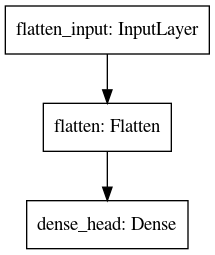

In [11]:
# We can plot our model here using plot_model()
plot_model(model0)

## Train model

**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: `categorical_crossentropy`; Metric: "accuracy"
- Use exactly 15  epochs for training
- Save your training results in a variable named `history0`
- Plot your training results using the`plotTrain` method described in the Student API above.


Train on 2880 samples, validate on 720 samples
Epoch 1/15
2880/2880 [==============================] - 1s 394us/sample - loss: 2.3659 - accuracy: 0.7017 - val_loss: 1.2134 - val_accuracy: 0.6431
Epoch 2/15
2880/2880 [==============================] - 1s 238us/sample - loss: 1.7521 - accuracy: 0.7597 - val_loss: 0.8366 - val_accuracy: 0.8361
Epoch 3/15
2880/2880 [==============================] - 1s 209us/sample - loss: 1.4049 - accuracy: 0.7830 - val_loss: 1.1557 - val_accuracy: 0.8319
Epoch 4/15
2880/2880 [==============================] - 0s 158us/sample - loss: 1.4629 - accuracy: 0.7931 - val_loss: 1.1628 - val_accuracy: 0.7056
Epoch 5/15
2880/2880 [==============================] - 0s 167us/sample - loss: 1.4135 - accuracy: 0.7962 - val_loss: 0.6594 - val_accuracy: 0.8667
Epoch 6/15
2880/2880 [==============================] - 0s 167us/sample - loss: 1.2538 - accuracy: 0.8108 - val_loss: 0.8268 - val_accuracy: 0.8556
Epoch 7/15
2880/2880 [==============================] - 0s 172us/

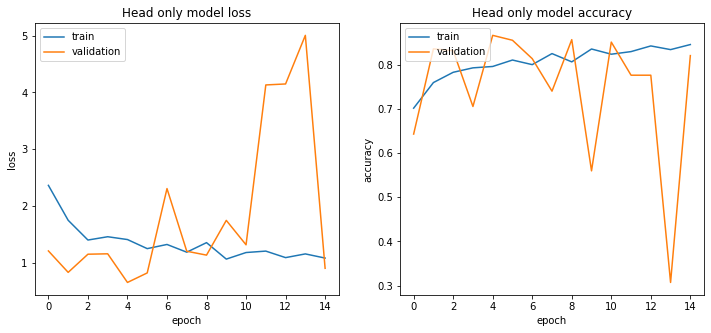

In [12]:
model_name0 = "Head only"

### BEGIN SOLUTION
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model0.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history0 = model0.fit(X_train_, y_train_, epochs=15, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history0, model_name0)
### END SOLUTION

**Expected outputs (your model may produce similar although not identical results):**  
<table> 
    <tr> 
        <td>  
            Training accuracy
        </td>
        <td>
         0.7965
        </td>
    </tr>
    <tr> 
        <td>
            Validation accuracy
        </td>
        <td>
         0.8319
        </td>
    </tr>

</table>



## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.


In [13]:
# Set num_parameters0 equal to the number of weights in the model
num_parameters0 = None

### BEGIN SOLUTION
num_parameters0 = model0.count_params()
### END SOLUTION

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  38402


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.

In [14]:
score0 = []

### BEGIN SOLUTION
score0 = model0.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

Head only: Test loss: 0.94 / Test accuracy: 0.78


Your test accuracy should be at least 0.6

## Save the trained model0 and history0 for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [15]:
helper.saveModel(model0, model_name0)
helper.saveModelNonPortable(model0, model_name0)
helper.saveHistory(history0, model_name0)

Directory ./models/Head only already exists, files will be over-written.
Model saved in directory ./models/Head only; create an archive of this directory and submit with your assignment.
Directory ./models/Head only already exists, files will be over-written.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/Head only/assets
Model saved in directory ./models/Head only; create an archive of this directory and submit with your assignment.
Directory ./models/Head only already exists, files will be over-written.


In [16]:
## Restore the model (make sure that it works)

model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a new model with a Dense layer providing 512 features plus the Classification head

**Question:** 

We will add more layers to the original model0. 

- You need to add **AT LEAST ONE** Dense layer followed by an activation function (for example, ReLU)
    - You can add more layers if you like
    
- Your very **FIRST** Dense layer should have **512** units.
    - Please name this Dense layer "dense_1" and the head layer "dense_head". 

**Hints:**
- Don't forget to flatten your input data!
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 

Hopefully your new model performs **better** than your first.

In [17]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_features_1 = 512

### BEGIN SOLUTION
from tensorflow.keras.layers import Dropout

model1 = Sequential()
model1.add(Flatten(input_shape=(X.shape[1:])))
model1.add(Dense(num_features_1, activation='relu', name='dense_1'))
model1.add(Dropout(0.2))
model1.add(Dense(num_cases, activation='softmax', name='dense_head'))
### END SOLUTION

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 19200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9830912   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_head (Dense)           (None, 2)                 1026      
Total params: 9,831,938
Trainable params: 9,831,938
Non-trainable params: 0
_________________________________________________________________


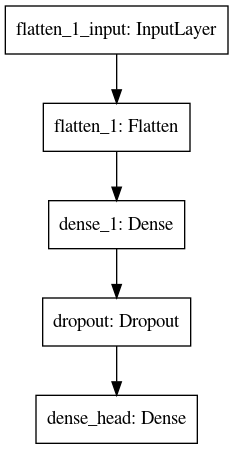

In [18]:
# Plot your model
plot_model(model1)

## Train your new model

**Question:**

Now that you have built your new model1,  you will compile and train model1. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: `categorical_crossentropy`; Metric: "accuracy"
- Use exactly 15  epochs for training
- Save your training results in a variable named `history1`
- Plot your training results using the`plotTrain` method described in the Student API above.


Train on 2880 samples, validate on 720 samples
Epoch 1/15
2880/2880 [==============================] - 9s 3ms/sample - loss: 4.0127 - accuracy: 0.6865 - val_loss: 0.4090 - val_accuracy: 0.8083
Epoch 2/15
2880/2880 [==============================] - 9s 3ms/sample - loss: 0.5841 - accuracy: 0.7597 - val_loss: 0.4833 - val_accuracy: 0.7944
Epoch 3/15
2880/2880 [==============================] - 10s 3ms/sample - loss: 0.4650 - accuracy: 0.7951 - val_loss: 0.3678 - val_accuracy: 0.8375
Epoch 4/15
2880/2880 [==============================] - 9s 3ms/sample - loss: 0.4462 - accuracy: 0.8174 - val_loss: 0.4043 - val_accuracy: 0.8319
Epoch 5/15
2880/2880 [==============================] - 9s 3ms/sample - loss: 0.4056 - accuracy: 0.8253 - val_loss: 0.3355 - val_accuracy: 0.8361
Epoch 6/15
2880/2880 [==============================] - 8s 3ms/sample - loss: 0.3844 - accuracy: 0.8451 - val_loss: 0.5085 - val_accuracy: 0.8264
Epoch 7/15
2880/2880 [==============================] - 9s 3ms/sample - loss

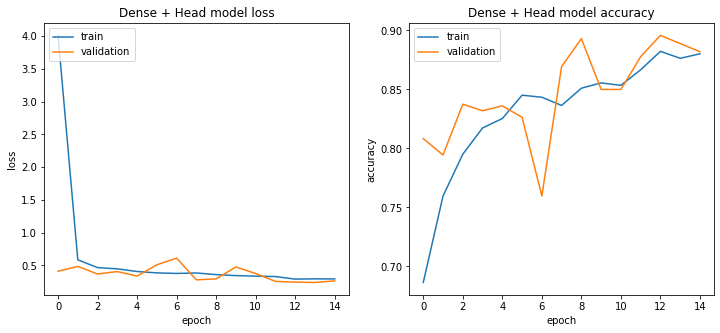

In [19]:
# Train the model using the API
model_name1 = "Dense + Head"

### BEGIN SOLUTION
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train_, y_train_, epochs=15, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history1, model_name1)
### END SOLUTION

**Expected outputs (there may be some differences because we only have one layer):**  
<table> 
    <tr> 
        <td>  
            Training accuracy
        </td>
        <td>
         0.8293
        </td>
    </tr>
    <tr> 
        <td>
            Validation accuracy
        </td>
        <td>
         0.8625
        </td>  
    </tr>
</table>

The loss and accuracy graphs of model1 are similiar to this:
<img src="./images/model1_loss_accuracy.png" style="width:600px;height:300px;">

We can see that the loss curves  decrease with epoch number, which means our model is learning!

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

In [20]:
# Set num_parameters1 equal to the number of weights in the model
num_parameters1 = None

### BEGIN SOLUTION
num_parameters1 = model1.count_params()
### END SOLUTION

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 9831938


## Evaluate the model

**Question:**

Evaluate the new model using the test dataset. Please store the model score in a variable named `score1`.   

In [21]:
score1 = []

### BEGIN SOLUTION
score1 = model1.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

Dense + Head: Test loss: 0.27 / Test accuracy: 0.89


Your new test score should be at least 0.8

# Save your trained model1 and history1

In [22]:
helper.saveModel(model1, model_name1)
helper.saveModelNonPortable(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory ./models/Dense + Head already exists, files will be over-written.
Model saved in directory ./models/Dense + Head; create an archive of this directory and submit with your assignment.
Directory ./models/Dense + Head already exists, files will be over-written.
INFO:tensorflow:Assets written to: ./models/Dense + Head/assets
Model saved in directory ./models/Dense + Head; create an archive of this directory and submit with your assignment.
Directory ./models/Dense + Head already exists, files will be over-written.


## Your own model (Optional)
Now you can build your own model using what you have learned from the course. Some ideas to try:
- Change the number of units (features) of your `Dense` layers. 
- Add `Dropout` layers; vary the parameter 
- Change the activation function
- Change the classifier
- ...

Observe the effect of each change on the Loss and Accuracy.


## Now Submit your assignment!
Please click on the blue button <span style="color: blue;"> **Submit** </span> in this notebook. 